## CIS508   
Cross Validation   
Author: SKLearn Documentation   
Source: https://scikit-learn.org/stable/modules/cross_validation.html   
        

## Load dataset
Let’s load the iris data set to fit a linear support vector machine on it:

In [29]:
# Let’s load the iris data set to fit a linear support vector machine on it:

import numpy as np

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

sample a training set while holding out 40% of the data for testing (evaluating) our classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

X_train.shape, y_train.shape

X_test.shape, y_test.shape

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using k - 1 of the folds as training data;

The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.   
   
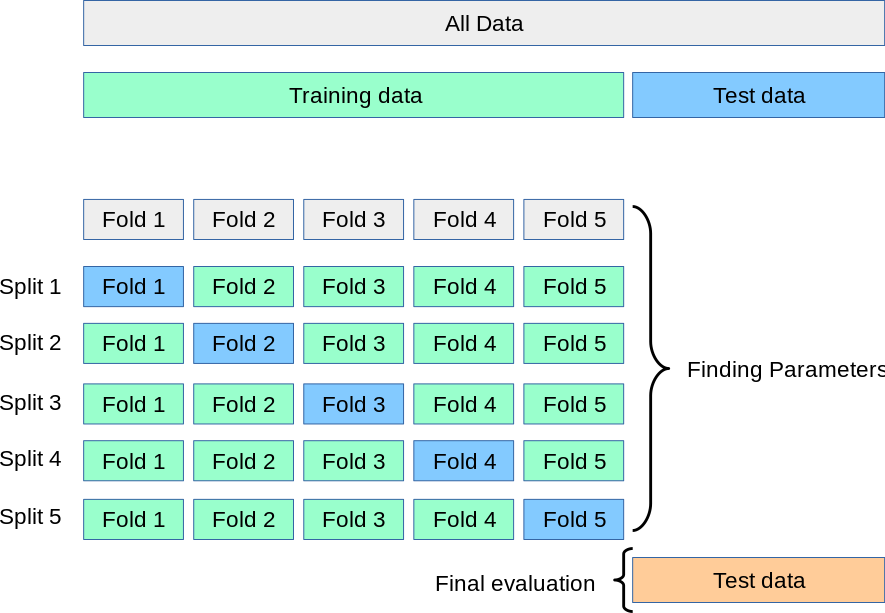
    

The simplest way to use cross-validation is to call the cross_val_score helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the iris dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time)

In the example, the mean score and the standard deviation are hence given by

In [17]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [18]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter   
   
See The scoring parameter: defining model evaluation rules for details. In the case of the Iris dataset, the samples are balanced across target classes hence the accuracy and the F1-score are almost equal.   
    

In [19]:
from sklearn import metrics
scores = cross_val_score(
    clf, X, y, cv=5, scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

It is also possible to use other cross validation strategies by passing a cross validation iterator instead, for instance:

In [21]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ])

Another option is to use an iterable yielding (train, test) splits as arrays of indices, for example:

In [20]:
def custom_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
        idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
        yield idx, idx
        i += 1

custom_cv = custom_cv_2folds(X)
cross_val_score(clf, X, y, cv=custom_cv)

array([1.        , 0.97333333])

## Data transformation with held out data

Just as it is important to test a predictor on data held-out from training, preprocessing (such as standardization, feature selection, etc.) and similar data transformations similarly should be learnt from a training set and applied to held-out data for prediction:

In [10]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

0.9333333333333333

A Pipeline makes it easier to compose estimators, providing this behavior under cross-validation:

In [11]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.93333333, 0.95555556, 0.93333333, 0.97777778])

## The cross_validate function

The cross_validate function differs from cross_val_score in two ways:

     It allows specifying multiple metrics for evaluation.

     It returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.

For single metric evaluation, where the scoring parameter is a string, callable or None, the keys will be - ['test_score', 'fit_time', 'score_time']

And for multiple metric evaluation, the return value is a dict with the following keys - ['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']

return_train_score is set to False by default to save computation time. To evaluate the scores on the training set as well you need to set it to True.

You may also retain the estimator fitted on each training set by setting return_estimator=True.

The multiple metrics can be specified either as a list, tuple or set of predefined scorer names:

In [22]:
# cross validate function with multiple metric evaluation

# define as list or tuple
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
sorted(scores.keys())

scores['test_recall_macro']

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

Or as a dict mapping scorer name to a predefined or custom scoring function:

In [23]:
# define as dict
from sklearn.metrics import make_scorer
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring,
                        cv=5, return_train_score=True)
sorted(scores.keys())


scores['train_rec_macro']

array([0.975     , 0.975     , 0.99166667, 0.98333333, 0.98333333])

Here is an example of cross_validate using a single metric:

In [24]:
# example of cross validate using a single metric
scores = cross_validate(clf, X, y,
                        scoring='precision_macro', cv=5,
                        return_estimator=True)
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

## Obtaining Predictions by cross-validation

The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

The function cross_val_predict is appropriate for:

1) Visualization of predictions obtained from different models.
2) Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.

Warning: Note on inappropriate usage of cross_val_predict
The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalization error.


## Example Plotting Cross Validated Predictions

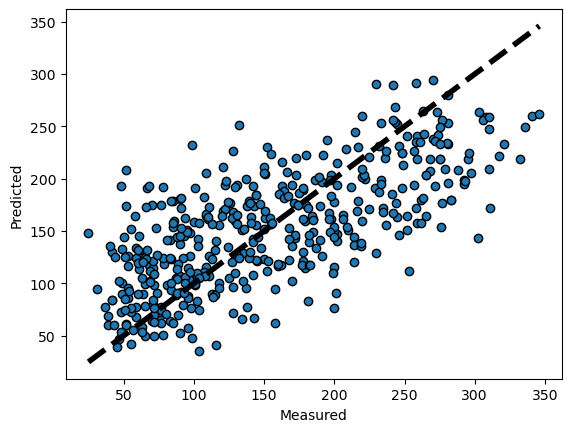

In [25]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
X, y = datasets.load_diabetes(return_X_y=True)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

## Example Recursive feature elimination with cross-validation

Optimal number of features : 3


C:\Users\elluque\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


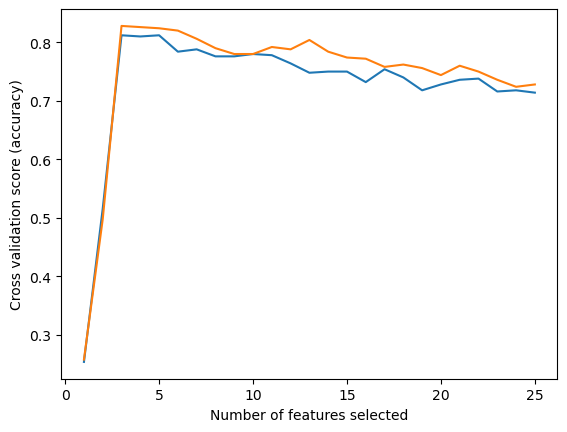

In [26]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(
    n_samples=1000,
    n_features=25,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    random_state=0,
)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

## Further examples provided on the source documentation URL   
   
https://scikit-learn.org/stable/modules/cross_validation.html   